# Interpolating ACGAN samples from different classes

In [84]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

import torch

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
!pip install torch-summary
from torchsummary import summary
from torchvision.utils import save_image
from torchvision.utils import make_grid

import gitpath
HOME_PATH = gitpath.root()
sys.path.append(HOME_PATH)

In [14]:
n_epochs = 50
batch_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_workers = 8
num_classes = 10
latent_dim = 100
img_size = 32
channels = 3
sample_interval = 500

dcgan_img_path = os.path.join(HOME_PATH, 'images', 'dcgan')
dcgan_FOLDER = os.path.join(HOME_PATH, 'saved_model', 'dcgan')

acgan_img_path = os.path.join(HOME_PATH, 'images', 'acgan')
acgan_FOLDER = os.path.join(HOME_PATH, 'saved_model', 'acgan')

wgan_img_path = os.path.join(HOME_PATH, 'images', 'wgan_clipping')
wgan_FOLDER = os.path.join(HOME_PATH, 'saved_model', 'wgan_clipping')

## Step 1: Set up preprocessing functions

In [10]:
# useful libraries
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
        ])

In [11]:
# do NOT change these
import torchvision.datasets as dset
from torch.utils.data import DataLoader

# a few arguments, do NOT change these
DATA_ROOT = os.path.join(HOME_PATH, "data")

# construct dataset
dataset = dset.CIFAR10(
    root=DATA_ROOT,
    train=True,
    download=True,
    transform=transform 
)

# construct dataloader
dataloader = DataLoader(
    dataset, 
    batch_size=batch_size,  # your code
    shuffle=True,     # your code
    num_workers=n_workers
)

Files already downloaded and verified


In [12]:
# specify the device for computation

# GPU check                
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")

Run on GPU...


## Step 3: Load Generators

#### DCGAN

In [13]:
from models.DCGAN import *

# Model Definition  
DCGAN_G = Generator(latent_dim).to(device)
DCGAN_D = Discriminator().to(device)

# Load state dict
state_dict_G = torch.load(os.path.join(dcgan_FOLDER, 'generator.pth'))
DCGAN_G.eval()
state_dict_D = torch.load(os.path.join(dcgan_FOLDER, 'discriminator.pth'))
DCGAN_D.load_state_dict(state_dict_D)
DCGAN_D.eval()

# Check if on GPU
assert(next(DCGAN_G.parameters()).is_cuda)
assert(next(DCGAN_D.parameters()).is_cuda)

#### ACGAN

In [69]:
from models.ACGAN import *

# Model Definition  
ACGAN_G = Generator(latent_dim+num_classes).to(device) # add ten in latent space to encode class info
ACGAN_D = Discriminator(num_classes).to(device)

# Load state dict
state_dict_G = torch.load(os.path.join(acgan_FOLDER, 'generator.pth')) # change the path to your own checkpoint file
ACGAN_G.load_state_dict(state_dict_G)
ACGAN_G.eval()
state_dict_D = torch.load(os.path.join(acgan_FOLDER, 'discriminator.pth')) # change the path to your own checkpoint file
ACGAN_D.load_state_dict(state_dict_D)
ACGAN_D.eval()

# Check if on GPU
assert(next(ACGAN_G.parameters()).is_cuda)
assert(next(ACGAN_D.parameters()).is_cuda)

#### WGAN

In [70]:
from models.WGAN import *

# Model Definition  
WGAN_G = Generator(latent_dim).to(device) 
WGAN_D = Discriminator().to(device)

# Load state dict
state_dict_G = torch.load(os.path.join(wgan_FOLDER, 'generator.pth')) # change the path to your own checkpoint file
WGAN_G.load_state_dict(state_dict_G)
WGAN_G.eval()
state_dict_D = torch.load(os.path.join(wgan_FOLDER, 'discriminator.pth')) # change the path to your own checkpoint file
WGAN_D.load_state_dict(state_dict_D)
WGAN_D.eval()

# Check if on GPU
assert(next(WGAN_G.parameters()).is_cuda)
assert(next(WGAN_D.parameters()).is_cuda)

## Step 4: Visualize some results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


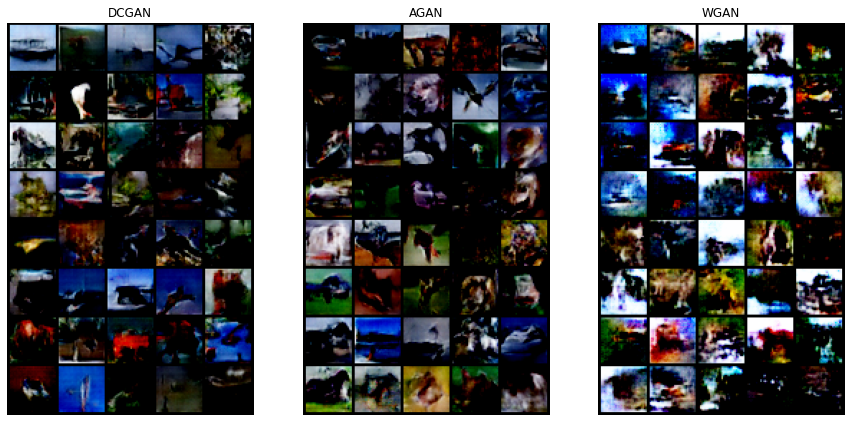

In [102]:
fixed_random_z = torch.randn(batch_size, latent_dim)

gen_class = np.random.randint(0, num_classes, batch_size)
z_labels = torch.zeros(batch_size, num_classes)
z_labels[np.arange(batch_size), gen_class] = 1.0
fixed_random_z_label = torch.concat((fixed_random_z, z_labels), 1)

dcgan_images = make_grid(DCGAN_G(fixed_random_z.to(device)).data[:40], nrow = 5).permute(1,2,0).to('cpu').detach().numpy()
acgan_images = make_grid(ACGAN_G(fixed_random_z_label.to(device)).data[:40], nrow = 5).permute(1,2,0).to('cpu').detach().numpy()
wgan_images = make_grid(WGAN_G(fixed_random_z.to(device)).data[:40], nrow = 5).permute(1,2,0).to('cpu').detach().numpy()

plt.figure(figsize=(15,9))

plt.subplot(1,3,1)
plt.imshow(dcgan_images)
plt.axis("off")
plt.title("DCGAN")

plt.subplot(1,3,2)
plt.imshow(acgan_images)
plt.axis("off")
plt.title("AGAN")

plt.subplot(1,3,3)
plt.imshow(wgan_images)
plt.axis("off")
plt.title("WGAN")

plt.savefig(os.path.join(HOME_PATH, "images","sampling_results.png"))

## Step 5: Linear Interpolation Function

In [22]:
def interpolate_shape(generator, acgan_class = -1, n=10):
    z1 = torch.randn(latent_dim)    
    z2 = torch.randn(latent_dim)
    
    if (acgan_class >= 0):
        z1_labels = torch.zeros(num_classes)
        z1_labels[acgan_class] = 1.0
        z1 = torch.concat((z1, z1_labels), 0)  
        z2_labels = torch.zeros(num_classes)
        z2_labels[acgan_class] = 1.0
        z2 = torch.concat((z2, z2_labels), 0)
    
    z_np = torch.stack([z1.to(device) + (z2.to(device) - z1.to(device))*t for t in np.linspace(0, 1, n)])
    
    interpolate_list = generator(z_np)
    interpolate_list = interpolate_list.permute(0, 2, 3, 1).to('cpu').detach().numpy()

    return z_np, interpolate_list

#### DCGAN

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

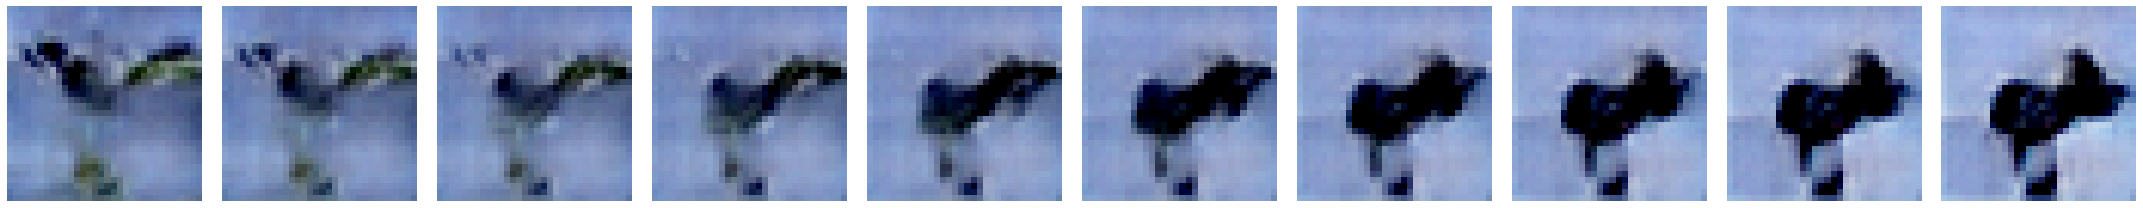

In [67]:
z_np, interpolate_list = interpolate_shape(DCGAN_G, acgan_class = -1, n=10)

fig = plt.figure(figsize=(30,3))

# Plot the data
for i in range(10):
    gen_img = interpolate_list[i]
    ax = fig.add_subplot(1,10,i+1)
    ax.imshow(gen_img)
    ax.axis("off")

plt.tight_layout()
plt.savefig(os.path.join(HOME_PATH, "images","dcgan_interpolation.png"))

#### ACGAN


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

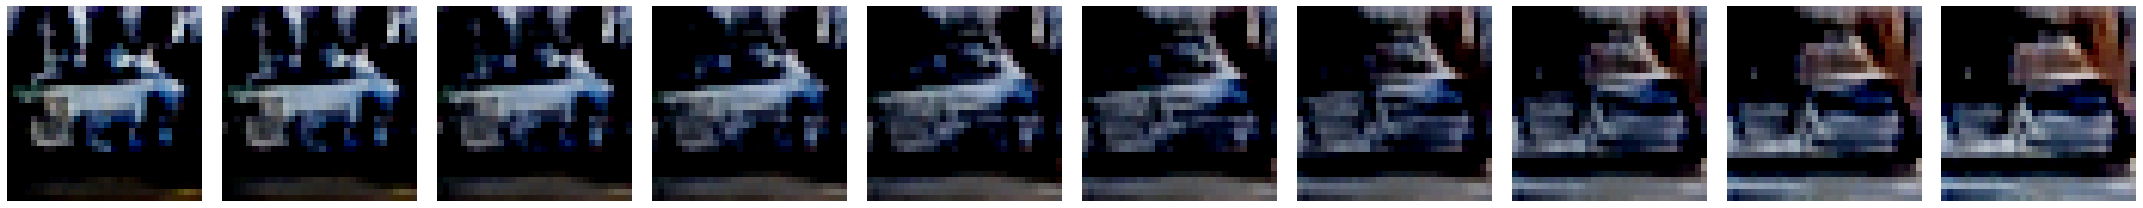

In [74]:
z_np, interpolate_list = interpolate_shape(ACGAN_G, acgan_class = 1, n=10)

fig = plt.figure(figsize=(30,3))

# Plot the data
for i in range(10):
    gen_img = interpolate_list[i]
    ax = fig.add_subplot(1,10,i+1)
    ax.imshow(gen_img)
    ax.axis("off")

plt.tight_layout()
plt.savefig(os.path.join(HOME_PATH, "images","acgan_interpolation.png"))

#### WGAN


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

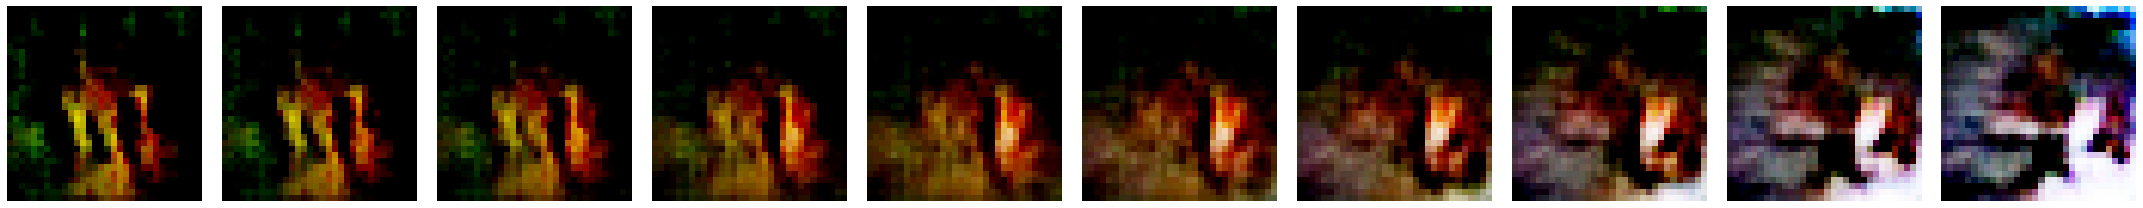

In [77]:
z_np, interpolate_list = interpolate_shape(WGAN_G, acgan_class = -1, n=10)

fig = plt.figure(figsize=(30,3))

# Plot the data
for i in range(10):
    gen_img = interpolate_list[i]
    ax = fig.add_subplot(1,10,i+1)
    ax.imshow(gen_img)
    ax.axis("off")

plt.tight_layout()
plt.savefig(os.path.join(HOME_PATH, "images","wgan_interpolation.png"))